# Uncertainty-Aware Evaluation in Healthcare ML

This notebook demonstrates an uncertainty-aware evaluation framework for healthcare machine learning. 
The focus is not on maximizing accuracy, but on identifying regions where model predictions become unstable or risky, and where automation should be deferred.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats

## Data Overview
We use the Wisconsin Diagnostic Breast Cancer dataset, containing 30 numeric tumor features and a binary diagnosis label.


In [2]:
df=pd.read_csv("Projects/Bio-projects/data/breast+cancer+wisconsin+diagnostic/wdbc_with_header_diag.csv")

In [3]:
df.head()

,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.head().T


,0,1,2,3,4
ID,842302,842517,84300903,84348301,84358402
Diagnosis,M,M,M,M,M
radius_mean,17.99,20.57,19.69,11.42,20.29
texture_mean,10.38,17.77,21.25,20.38,14.34
perimeter_mean,122.8,132.9,130.0,77.58,135.1
area_mean,1001.0,1326.0,1203.0,386.1,1297.0
smoothness_mean,0.1184,0.08474,0.1096,0.1425,0.1003
compactness_mean,0.2776,0.07864,0.1599,0.2839,0.1328
concavity_mean,0.3001,0.0869,0.1974,0.2414,0.198
concave_points_mean,0.1471,0.07017,0.1279,0.1052,0.1043


In [5]:
df.shape

(569, 32)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       569 non-null    int64  
 1   Diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
df.describe()

,ID,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
df.isnull().sum().sum()

np.int64(0)

In [9]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
564    False
565    False
566    False
567    False
568    False
Length: 569, dtype: bool

In [10]:
df['radius_mean'].describe()

count    569.000000
mean      14.127292
std        3.524049
min        6.981000
25%       11.700000
50%       13.370000
75%       15.780000
max       28.110000
Name: radius_mean, dtype: float64

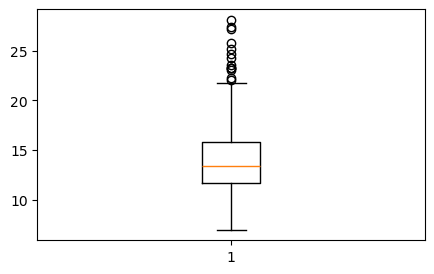

In [11]:
plt.figure(figsize=(5,3))             
plt.boxplot(df['radius_mean'])
plt.show()

### Note on Outliers
In healthcare data, extreme values may represent clinically significant or worst-case scenarios rather than noise. Therefore, outliers are not removed to preserve data integrity and avoid masking high-risk cases.


In [12]:
df.columns

Index(['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

## Feature Intuition
The dataset captures three broad signal types:
- Size-related features (radius, area, perimeter)
- Shape and boundary irregularity (concavity, concave points)
- Structural complexity (fractal dimension, symmetry)

Each feature appears as mean, standard error (SE), and worst-case values, which allows us to study not just magnitude but stability.


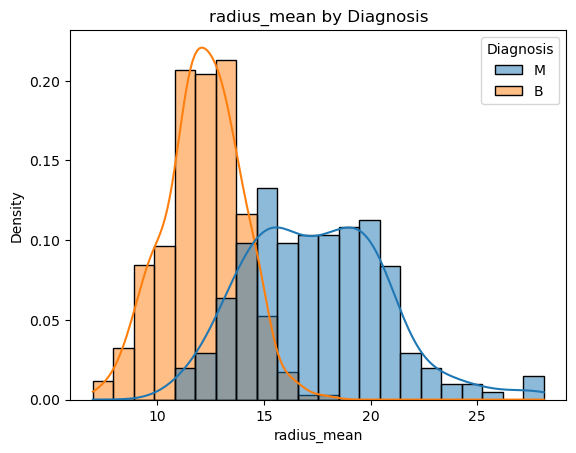

In [13]:
sns.histplot(data=df, x='radius_mean', hue='Diagnosis', kde=True, stat='density', common_norm=False)
plt.title("radius_mean by Diagnosis")
plt.show()

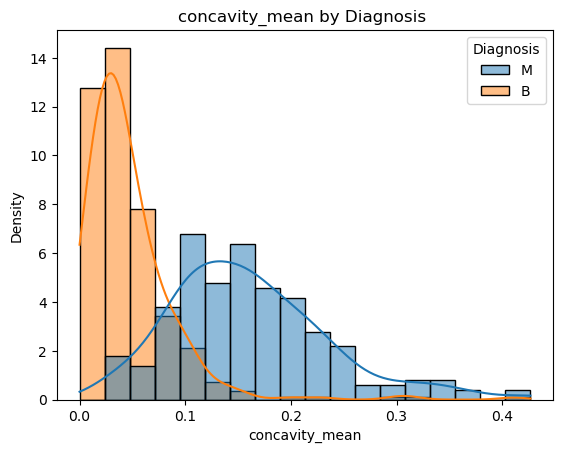

In [14]:
sns.histplot(data=df, x=df['concavity_mean'], hue='Diagnosis', kde=True, stat='density', common_norm=False)
plt.title("concavity_mean by Diagnosis ")
plt.show()

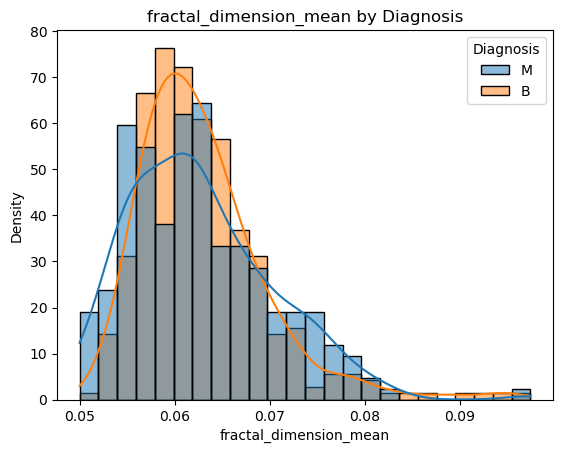

In [15]:
sns.histplot(data=df, x='fractal_dimension_mean', hue='Diagnosis', kde=True, stat='density', common_norm=False)
plt.title("fractal_dimension_mean by Diagnosis")
plt.show()

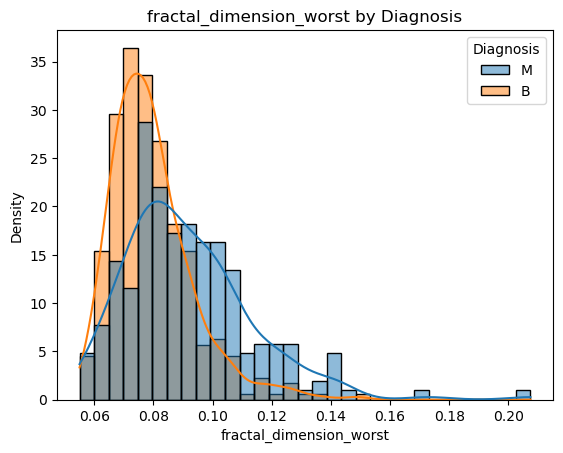

In [16]:
sns.histplot(data=df, x='fractal_dimension_worst', hue='Diagnosis', kde=True, stat='density', common_norm=False)
plt.title("fractal_dimension_worst by Diagnosis")
plt.show()

<Axes: xlabel='radius_mean', ylabel='concavity_mean'>

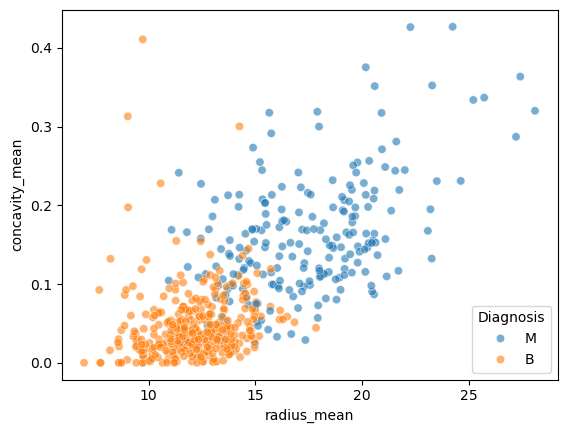

In [17]:
sns.scatterplot(
    data=df,
    x='radius_mean',
    y='concavity_mean',
    hue='Diagnosis',
    alpha=0.6
)

Insight:“Despite overall separation, a dense overlap region exists where class distinction is ambiguous, motivating uncertainty-aware evaluation.”

## Baseline Model
A simple logistic regression model is used as a reference point to establish baseline performance.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

X = df[['radius_mean', 'concavity_mean', 'fractal_dimension_mean']]
y = (df['Diagnosis'] == 'M').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [19]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [20]:
auc = roc_auc_score(y_test, y_pred_proba)
auc


np.float64(0.9519916142557652)


## Uncertainty Signals
Rather than relying on predictions alone, we derive uncertainty signals that capture when model decisions become fragile:

- **Feature instability**: high variability (SE) indicating noisy or inconsistent measurements
- **Internal disagreement**: divergence between mean and worst-case feature summaries, suggesting sensitivity to extreme values

These signals are combined into an uncertainty score to surface decision regions where small changes in data can disproportionately affect outcomes.



In [21]:
df.columns

Index(['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [22]:
threshold = np.quantile(df['fractal_dimension_se'], 0.75)

df['Instability_flag'] = df['fractal_dimension_se'] > threshold

In [23]:
df['Instability_flag'] = (
    (df['fractal_dimension_se'] > df['fractal_dimension_se'].quantile(0.75)) |
    (df['symmetry_se'] > df['symmetry_se'].quantile(0.75)) |
    (df['concavity_se'] > df['concavity_se'].quantile(0.75))
)

In [24]:
df['Instability_flag'].value_counts(normalize=True)

Instability_flag
False    0.564148
True     0.435852
Name: proportion, dtype: float64

In [25]:
fd_thresh = np.quantile(df['fractal_dimension_se'], 0.75)
sym_thresh = np.quantile(df['symmetry_se'], 0.75)
conc_thresh = np.quantile(df['concavity_se'], 0.75)

df['Instability_flag'] = (
    (df['fractal_dimension_se'] > fd_thresh) |
    (df['symmetry_se'] > sym_thresh) |
    (df['concavity_se'] > conc_thresh)
)

In [26]:
df['Instability_flag'].value_counts(normalize=True)

Instability_flag
False    0.564148
True     0.435852
Name: proportion, dtype: float64

In [27]:
# Compute absolute gaps
fd_gap = np.abs(df['fractal_dimension_worst'] - df['fractal_dimension_mean'])
conc_gap = np.abs(df['concavity_worst'] - df['concavity_mean'])

# Compute thresholds
fd_gap_thresh = np.quantile(fd_gap, 0.70)
conc_gap_thresh = np.quantile(conc_gap, 0.70)

# Disagreement flag (OR rule)
df['Disagreement_flag'] = (
    (fd_gap > fd_gap_thresh) |
    (conc_gap > conc_gap_thresh)
)


In [28]:
df['Disagreement_flag'].value_counts(normalize=True)

Disagreement_flag
False    0.615114
True     0.384886
Name: proportion, dtype: float64

In [29]:
df['Uncertainty_flag'] = (
    df['Instability_flag'] | df['Disagreement_flag']
)

In [30]:
df['Uncertainty_flag'].value_counts(normalize=True)

Uncertainty_flag
True     0.601054
False    0.398946
Name: proportion, dtype: float64

In [31]:
instability_count = (
    (df['fractal_dimension_se'] > np.quantile(df['fractal_dimension_se'], 0.75)).astype(int) +
    (df['symmetry_se'] > np.quantile(df['symmetry_se'], 0.75)).astype(int) +
    (df['concavity_se'] > np.quantile(df['concavity_se'], 0.75)).astype(int)
)

df['Instability_flag_refined'] = instability_count >= 2

**“A refined instability flag was later introduced to reduce noise by requiring consistency across multiple variability indicators.”**

In [32]:
df['Instability_flag_refined'].value_counts(normalize=True)

Instability_flag_refined
False    0.760984
True     0.239016
Name: proportion, dtype: float64

In [33]:
df['Uncertainty_flag_refined'] = (
    df['Instability_flag_refined'] | df['Disagreement_flag']
)

df['Uncertainty_flag_refined'].value_counts(normalize=True)

Uncertainty_flag_refined
False    0.514938
True     0.485062
Name: proportion, dtype: float64

In [34]:
pd.crosstab(df['Diagnosis'], df['Uncertainty_flag_refined'], normalize='index')

Uncertainty_flag_refined,False,True
Diagnosis,,
B,0.694678,0.305322
M,0.212264,0.787736


In [35]:
df['Uncertainty_score'] = (
    df['Instability_flag_refined'].astype(int) +
    df['Disagreement_flag'].astype(int)
)


In [36]:
df['Uncertainty_score'].value_counts(normalize=True)

Uncertainty_score
0    0.514938
1    0.346221
2    0.138840
Name: proportion, dtype: float64

In [37]:
def risk_profile(score):   # decision risk not medical risk
    if score == 0:
        return 'Low risk (stable)'
    elif score == 1:
        return 'Moderate risk (review)'
    else:
        return 'High risk (gray zone)'

df['Risk_profile'] = df['Uncertainty_score'].apply(risk_profile)

In [38]:
test_df = X_test.copy()
test_df['Diagnosis'] = y_test.values
test_df['Pred_prob'] = y_pred_proba
test_df['Risk_profile'] = df.loc[X_test.index, 'Risk_profile']

In [39]:
test_df['Pred_label'] = (test_df['Pred_prob'] >= 0.5).astype(int)

### Decision Risk Profiles
Based on the uncertainty score, cases are grouped into low, moderate, and high-risk (gray zone) profiles to reflect how safely model predictions can be acted upon versus where human review is required.


In [40]:
pd.crosstab(df['Diagnosis'], df['Risk_profile'], normalize='index')

Risk_profile,High risk (gray zone),Low risk (stable),Moderate risk (review)
Diagnosis,,,
B,0.078431,0.694678,0.226891
M,0.240566,0.212264,0.547170


### Evaluation Matrix
Rather than evaluating performance globally, we analyze errors and false negatives across risk profiles to understand where model failures concentrate and how decision risk varies by uncertainty level.


In [41]:
pd.crosstab(
    test_df['Risk_profile'],
    test_df['Pred_label'] != test_df['Diagnosis'],
    normalize='index'
)

col_0,False,True
Risk_profile,,
High risk (gray zone),0.818182,0.181818
Low risk (stable),0.946667,0.053333
Moderate risk (review),0.760870,0.239130


## Error Concentration Analysis
We evaluate where model errors occur relative to risk profiles to understand practical deployment risk.


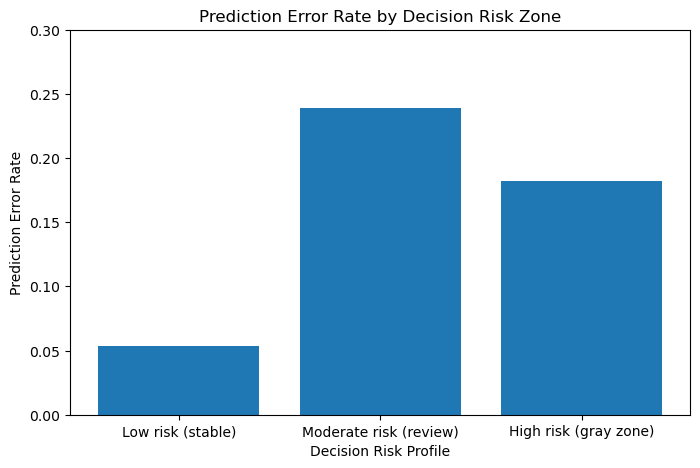

In [42]:
error_rates = pd.DataFrame({
    'Risk_profile': ['Low risk (stable)', 'Moderate risk (review)', 'High risk (gray zone)'],
    'Error_rate': [0.053333, 0.239130, 0.181818]
})

plt.figure(figsize=(8, 5))
plt.bar(error_rates['Risk_profile'], error_rates['Error_rate'])
plt.ylabel('Prediction Error Rate')
plt.xlabel('Decision Risk Profile')
plt.title('Prediction Error Rate by Decision Risk Zone')

plt.ylim(0, 0.3)
plt.show()

In [43]:
test_df['Predicted'] = np.where(test_df['Pred_prob'] > 0.5, 'M', 'B')


In [44]:
test_df['False_Negative'] = ( (test_df['Diagnosis'] == 1) & (test_df['Pred_label'] == 0) )

In [45]:
pd.crosstab(
    test_df['Risk_profile'],
    test_df['False_Negative'],
    normalize='index'
)

False_Negative,False,True
Risk_profile,,
High risk (gray zone),0.863636,0.136364
Low risk (stable),0.973333,0.026667
Moderate risk (review),0.782609,0.217391


## Robustness Check
To verify whether uncertainty patterns are model-specific, we repeat the analysis using all available features.


In [46]:
feature_cols = [col for col in df.columns 
                if col not in ['ID', 'Diagnosis',
                               'Instability_flag_refined',
                               'Disagreement_flag',
                               'Uncertainty_flag_refined',
                               'Uncertainty_score',
                               'Risk_profile']]

In [47]:
original_features = [
    col for col in df.columns
    if col.endswith('_mean') or col.endswith('_se') or col.endswith('_worst')
]


In [48]:
len(original_features)

30

In [49]:
original_features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave_points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave_points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave_points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [50]:
X = df[original_features]
y = (df['Diagnosis'] == 'M').astype(int)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [51]:
from sklearn.linear_model import LogisticRegression

model_full = LogisticRegression(max_iter=3000)
model_full.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [52]:
y_pred_proba_full = model_full.predict_proba(X_test)[:, 1]

In [53]:
from sklearn.metrics import roc_auc_score

auc_full = roc_auc_score(y_test, y_pred_proba_full)
auc_full

np.float64(0.9949685534591195)

In [54]:


test_df_full = X_test.copy()
test_df_full['Diagnosis'] = y_test.values
test_df_full['Pred_prob'] = y_pred_proba_full
test_df_full['Pred_label'] = (test_df_full['Pred_prob'] >= 0.5).astype(int)

test_df_full['Risk_profile'] = df.loc[X_test.index, 'Risk_profile']

In [55]:
pd.crosstab(
    test_df_full['Risk_profile'],
    test_df_full['Pred_label'] != test_df_full['Diagnosis'],
    normalize='index'
)


col_0,False,True
Risk_profile,,
High risk (gray zone),1.000000,0.000000
Low risk (stable),0.960000,0.040000
Moderate risk (review),0.891304,0.108696


**“Uncertainty patterns persist despite higher AUC”**

In [56]:
test_df_full['False_Negative'] = (
    (test_df_full['Diagnosis'] == 1) &
    (test_df_full['Pred_label'] == 0)
)

pd.crosstab(
    test_df_full['Risk_profile'],
    test_df_full['False_Negative'],
    normalize='index'
)


False_Negative,False,True
Risk_profile,,
High risk (gray zone),1.000000,0.000000
Low risk (stable),0.973333,0.026667
Moderate risk (review),0.891304,0.108696


In healthcare settings, false negatives represent the most harmful failure mode and are therefore analyzed explicitly by risk profile.
